In [ ]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
# plt.style.use('dark_background')
plt.style.use('seaborn-notebook')
from data_load_preprocess import data
from collections import OrderedDict


import torch
from torch.autograd import Variable
from viz import viz
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

# load results from a directory

In [ ]:
out_dir_main = '/scratch/users/vision/yu_dl/raaz.rsk/adam_vs_sgd'
print(os.listdir(out_dir_main))
folder = 'long_full'

In [ ]:
# depending on how much is saved, this may take a while
out_dir = oj(out_dir_main, folder)
fnames = os.listdir(out_dir)
results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in fnames]
results = pd.concat(results_list, axis=1).T.infer_objects()
# results.describe()
results.head()

# plot basic things for entire dataframe

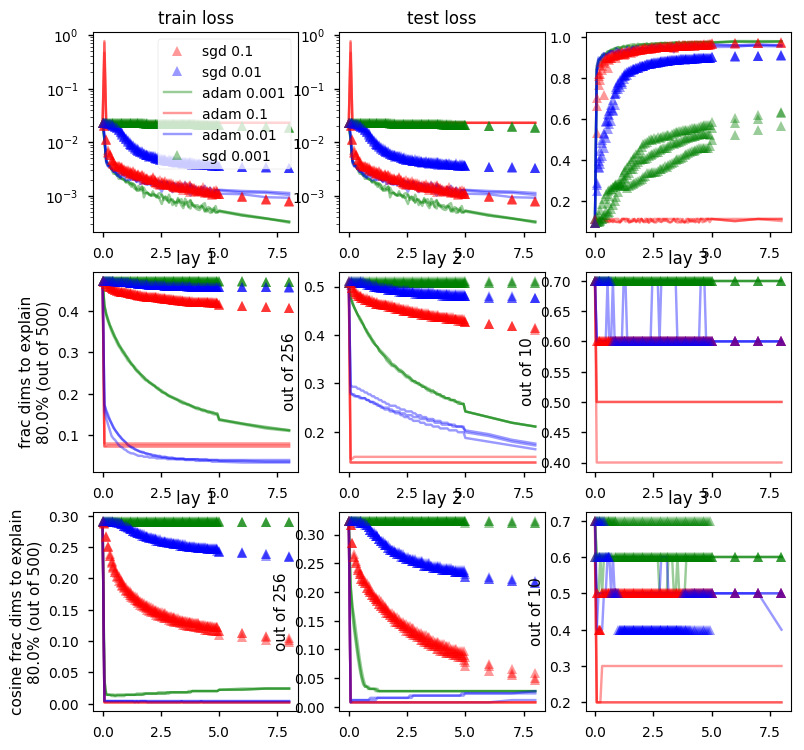

In [10]:
# params for plotting
plt.figure(figsize=(9, 9), dpi=100)
percent_to_explain = 0.80
dim_type1 = 'explained_var_dicts' # pca
dim_type2 = 'explained_var_dicts_cosine' # cosine, rbf, lap

def frac_dims_to_explain_X_percent(arr, percent_to_explain):
    dim, perc_explained = 0, 0
    while perc_explained <= percent_to_explain:
        perc_explained += arr[dim]
        dim += 1
    return dim / arr.size
    
dim_dicts = {}
R, C = 3, 3
for index, row in results.iterrows():
    # style for plotting
    style = '^' if row.optimizer == 'sgd' else '-'
    color = {0.1: 'red', 0.01: 'blue', 0.001: 'green'}[row.lr]
    alpha = 0.4
    
    
    # accs
    plt.subplot(R, C, 1)
    plt.plot(row.its, row.losses_train, style, label= row.optimizer + ' ' + str(row.lr), color=color, alpha=alpha)
    plt.yscale('log')
    plt.title('train loss')
    
    plt.subplot(R, C, 2)
    plt.plot(row.its, row.losses_train, style, color=color, alpha=alpha)
    plt.yscale('log')    
    plt.title('test loss')
    
    plt.subplot(R, C, 3)
    plt.plot(row.its, row.accs_test, style, color=color, alpha=alpha)
    plt.title('test acc')
    
    
    # PCs
    plt.subplot(R, C, 4)
    dim_dicts = row[dim_type1]
    plt.plot(row.its, [frac_dims_to_explain_X_percent(d['fc1.weight'], percent_to_explain) 
              for d in dim_dicts], style, color=color, alpha=alpha)
    plt.ylabel('frac dims to explain\n' + str(100 * percent_to_explain) + '% (out of ' + str(dim_dicts[0]['fc1.weight'].size)+ ')')
    plt.title('lay 1')
    
    plt.subplot(R, C, 5)
    plt.plot(row.its, [frac_dims_to_explain_X_percent(d['fc2.weight'], percent_to_explain) 
              for d in dim_dicts], style, color=color, alpha=alpha)
    plt.title('lay 2')
    plt.ylabel('out of ' + str(dim_dicts[0]['fc2.weight'].size))
    
    plt.subplot(R, C, 6)
    plt.plot(row.its, [frac_dims_to_explain_X_percent(d['fc3.weight'], percent_to_explain) 
              for d in dim_dicts], style, color=color, alpha=alpha)
    plt.title('lay 3')
    plt.ylabel('out of ' + str(dim_dicts[0]['fc3.weight'].size))
    
    
    # PCs
    plt.subplot(R, C, 7)
    dim_dicts = row[dim_type2]
    plt.plot(row.its, [frac_dims_to_explain_X_percent(d['fc1.weight'], percent_to_explain) 
              for d in dim_dicts], style, color=color, alpha=alpha)
    plt.ylabel('cosine frac dims to explain\n' + str(100 * percent_to_explain) + '% (out of ' + str(dim_dicts[0]['fc1.weight'].size)+ ')')
    plt.title('lay 1')
    
    plt.subplot(R, C, 8)
    plt.plot(row.its, [frac_dims_to_explain_X_percent(d['fc2.weight'], percent_to_explain) 
              for d in dim_dicts], style, color=color, alpha=alpha)
    plt.title('lay 2')
    plt.ylabel('out of ' + str(dim_dicts[0]['fc2.weight'].size))
    
    plt.subplot(R, C, 9)
    plt.plot(row.its, [frac_dims_to_explain_X_percent(d['fc3.weight'], percent_to_explain) 
              for d in dim_dicts], style, color=color, alpha=alpha)
    plt.title('lay 3')
    plt.ylabel('out of ' + str(dim_dicts[0]['fc3.weight'].size))   
    

plt.subplot(R, C, 1)    
# remove duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

# look at the lay 1 weights

just plot them all (this takes ~2 mins)

In [ ]:
# plot all the weights
def plot_weights(W, im_shape=(28, 28)): # W is num_filters x im_size
    num_filters = W.shape[0]
    filts = W.reshape((num_filters, im_shape[0], im_shape[1]))
    R = math.floor(np.sqrt(num_filters))
    C = math.ceil(num_filters / R)
    ratio = 1.0 * R/C
    plt.figure(figsize=(6, 6*R/C))
    for i in range(num_filters):
        plt.subplot(R, C, i+1)
        plt.imshow(filts[i], cmap='gray')
        plt.axis('off')
    plt.subplots_adjust(hspace=0, wspace=0)

lr = 0.01
# for (lr, optimizer) in [(0.1, 'sgd'), (0.01, 'adam')]:
for optimizer in ['sgd', 'adam']:
    for lr in [0.1, 0.01, 0.001]:
        runs = results[results.lr==lr]
        runs = runs[runs.optimizer==optimizer]
        run = runs.iloc[0]
        weight_dict = run.weights
        min_key, max_key = min(weight_dict.keys()), max(weight_dict.keys())
    #     print('init', optimizer, 'lr=' + str(lr))
    #     w = ws[min_key]['fc1.weight']
    #     plot_weights(w)

        print('final', optimizer, 'lr=' + str(lr))
        w = weight_dict[max_key]['fc1.weight']
        plot_weights(w)
        plt.savefig('figs/' + optimizer + '_' + 'lr=' + str(lr) + '.pdf', dpi=300)
    #     plt.show()

# visualize pcs

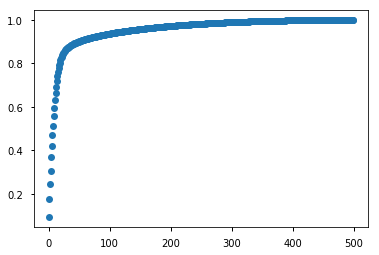

first pcs..


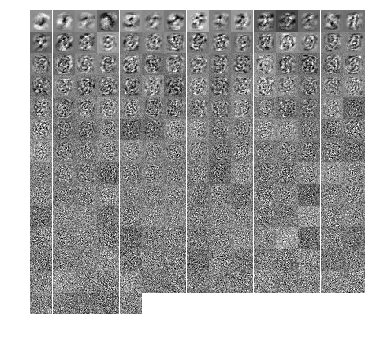

In [18]:
# pca
lr = 0.01
# for (lr, optimizer) in [(0.1, 'sgd'), (0.01, 'adam')]:
# for optimizer in ['sgd', 'adam']:
#     for lr in [0.1, 0.01, 0.001]:
optimizer, lr = 'adam', 0.01

# get w
runs = results[results.lr==lr]
runs = runs[runs.optimizer==optimizer]
run = runs.iloc[0]
weight_dict = run.weights
w = weight_dict[max(weight_dict.keys())]['fc1.weight']

# look at pcs
pca = PCA(n_components=w.shape[1])
pca.fit(w)
cum = deepcopy(pca.explained_variance_ratio_)
for i in range(1, len(cum)):
    cum[i] += cum[i-1]
plt.plot(cum, 'o')
plt.show()

print('first pcs..')
plot_weights(pca.components_[:200])
plt.show()